Project root: /Users/holgermaxfloelyng/Desktop/BioMed/MSc_Biomed/SEM_3/project/MLops/notebooks
Data dir: /Users/holgermaxfloelyng/Desktop/BioMed/MSc_Biomed/SEM_3/project/MLops/corruptmnist_v1 exists: True
Train: torch.Size([30000, 28, 28]) torch.Size([30000]) torch.float32 torch.int64
Test:  torch.Size([5000, 28, 28]) torch.Size([5000]) torch.float32 torch.int64


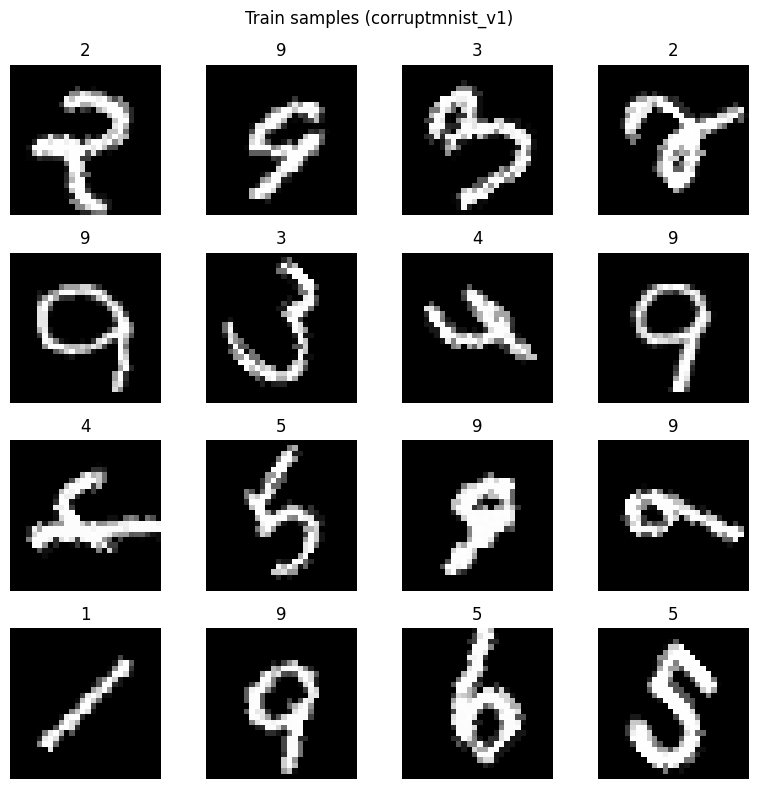

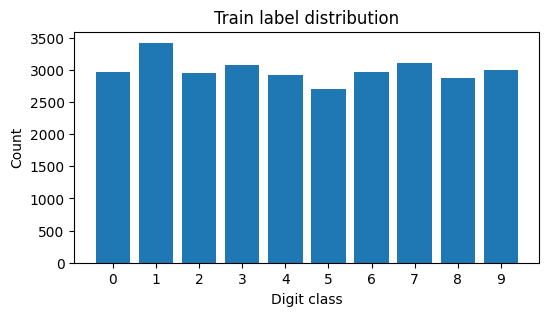

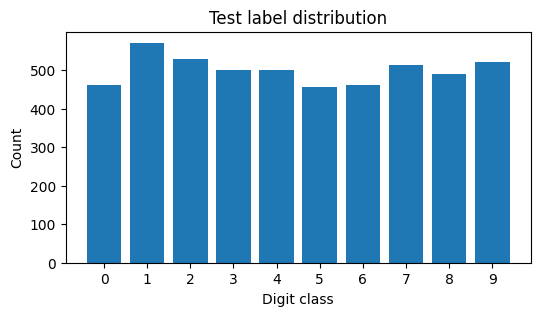

Train counts: [2961, 3423, 2948, 3073, 2926, 2709, 2975, 3107, 2875, 3003]
Test counts:  [460, 571, 530, 500, 500, 456, 462, 512, 489, 520]
Train pixel range: 0.0 to 1.0
Test pixel range:  0.0 to 1.0


In [5]:
from pathlib import Path
import torch
import matplotlib.pyplot as plt

# ----- Paths -----
PROJECT_ROOT = Path.cwd()  # run from repo root; if you're inside notebooks/, use Path.cwd().parent
DATA_DIR = PROJECT_ROOT.parent / "corruptmnist_v1"

# If you're running this from notebooks/, uncomment:
# PROJECT_ROOT = Path.cwd().parent
# DATA_DIR = PROJECT_ROOT / "corruptmnist_v1"

print("Project root:", PROJECT_ROOT)
print("Data dir:", DATA_DIR, "exists:", DATA_DIR.exists())

# ----- Load helpers -----
def load_pt(path: Path) -> torch.Tensor:
    obj = torch.load(path, map_location="cpu")
    if isinstance(obj, torch.Tensor):
        return obj
    if isinstance(obj, dict):
        for k in ["data", "images", "x", "inputs"]:
            if k in obj:
                return obj[k]
    raise TypeError(f"Unsupported .pt content in {path}: {type(obj)}")

def load_split(data_dir: Path, split: str):
    if split == "test":
        x = load_pt(data_dir / "test_images.pt")
        y = load_pt(data_dir / "test_target.pt")
        return x, y

    if split != "train":
        raise ValueError("split must be 'train' or 'test'")

    x_parts, y_parts = [], []
    for i in range(6):
        x_parts.append(load_pt(data_dir / f"train_images_{i}.pt"))
        y_parts.append(load_pt(data_dir / f"train_target_{i}.pt"))
    return torch.cat(x_parts, dim=0), torch.cat(y_parts, dim=0)

# ----- Load data -----
train_x, train_y = load_split(DATA_DIR, "train")
test_x, test_y = load_split(DATA_DIR, "test")

print("Train:", train_x.shape, train_y.shape, train_x.dtype, train_y.dtype)
print("Test: ", test_x.shape, test_y.shape, test_x.dtype, test_y.dtype)

# ----- Normalize shape to (N, H, W) for plotting -----
def to_nhw(x: torch.Tensor) -> torch.Tensor:
    # common shapes: (N, 28, 28) or (N, 1, 28, 28)
    if x.ndim == 4 and x.shape[1] == 1:
        return x[:, 0]
    if x.ndim == 3:
        return x
    raise ValueError(f"Unexpected image tensor shape: {x.shape}")

train_imgs = to_nhw(train_x)
test_imgs = to_nhw(test_x)

# ----- Plot random samples -----
def show_samples(images: torch.Tensor, labels: torch.Tensor, n: int = 16, title: str = ""):
    n = int(n)
    idx = torch.randperm(images.shape[0])[:n]
    side = int(n**0.5)
    if side * side != n:
        side = 4  # fallback grid
        n = side * side
        idx = idx[:n]

    fig, axes = plt.subplots(side, side, figsize=(8, 8))
    axes = axes.ravel()

    for ax, i in zip(axes, idx):
        img = images[i].cpu()
        lab = int(labels[i].cpu())
        ax.imshow(img, cmap="gray")
        ax.set_title(str(lab))
        ax.axis("off")

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

show_samples(train_imgs, train_y, n=16, title="Train samples (corruptmnist_v1)")

# ----- Label distribution -----
def plot_label_hist(labels: torch.Tensor, title: str = ""):
    labels = labels.cpu().long()
    counts = torch.bincount(labels, minlength=10)
    plt.figure(figsize=(6, 3))
    plt.bar(range(10), counts.numpy())
    plt.xticks(range(10))
    plt.title(title)
    plt.xlabel("Digit class")
    plt.ylabel("Count")
    plt.show()
    return counts

train_counts = plot_label_hist(train_y, "Train label distribution")
test_counts = plot_label_hist(test_y, "Test label distribution")

print("Train counts:", train_counts.tolist())
print("Test counts: ", test_counts.tolist())

# ----- Inspect value range (helpful for normalization decisions) -----
print("Train pixel range:", float(train_imgs.min()), "to", float(train_imgs.max()))
print("Test pixel range: ", float(test_imgs.min()), "to", float(test_imgs.max()))
